<a href="https://colab.research.google.com/github/varsha-raveendran/ai-in-medicine-exercises/blob/main/aim_graded_exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI in Medicine II – Graded Exercise on Time-to-event Analysis

Implement the estimator of the survival function of the exponential distribution derived
in Exercise 4 above. Use the breast cancer dataset from the hands-on exercise to compare
the Kaplan-Meier and parametric estimator for women with entry diagnoses of AH,
PDWA, and No PD as a function of years since biopsy. What does the graphic tell?
Explain whether the exponential distribution is suitable for this data?

## Installing Requirements

For the exercises, we will be relying on [scikit-survival](https://scikit-survival.readthedocs.io/), [pandas](https://pandas.pydata.org/), and [matplotlib](https://matplotlib.org/) to analyze time-to-event data. Please refer to their respective documentation for questions regarding their usage.

You can install everything by executing the following cell:

In [31]:
!pip install scikit-survival==0.17.2 matplotlib

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sksurv.util import Surv

%matplotlib inline

## Dataset

The following exercise is based on a study by [Dupont and Page (1985)](https://doi.org/10.1056/NEJM198501173120303). A cohort of 3303 Nashville women underwent benign breast biopsies between 1950 and 1968. The study obtained follow-up information from these women or their next of kin. The variables in this file are

| Column | Description |
| ------ | :---------- |
| id | patient identification number |
| entage | age at entry biopsy |
| follow | years of follow-up |
| pd | diagnosis of entry biopsy.<br/>`0`: no proliferative disease (NoPD);<br/>`1`: proliferative disease without atypia (PDWA);<br/>`2`: atypical hyperplasia (AH) |
| fate | fate at end of follow-up.<br/>`0`: censored;<br/>`1`: invasive breast cancer |
| fh | first degree family history of breast cancer.<br/> `0`: no;<br/>`1`: yes |


In [33]:
breast_data = pd.read_csv(
    "https://gist.githubusercontent.com/sebp/60b8457760316f4213ee920eb8a75dc4/raw/dc060bf20d37bf71fd865aeff528aaa99dbcbd90/6.ex.Breast.csv",
    index_col="id"
)

breast_data.head()

,entage,follow,pd,fate,fh
id,,,,,
1,30,14.863791,0,0,0
2,45,24.169746,0,0,0
3,35,23.323751,0,0,0
4,47,17.475702,0,0,0
5,30,28.438057,1,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f28609d1a50>,
      dtype=object)

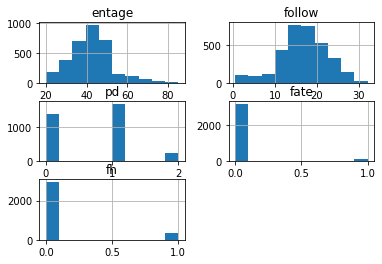

In [34]:
breast_data.hist()

### Kaplan-Meier estimate

Plot Kaplan–Meier breast cancer free survival curves for women with entry diagnoses of AH, PDWA, and No PD as a function of years since biopsy. Use time since entry biopsy as the time variable. What does the graphic tell? Is this a useful graphic? If not, why not? 

*HINT*: Consider the age distribution of entry biopsy for these three diagnoses.

The Kaplan-Meier curve can be estimated via [kaplan_meier_estimator](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.nonparametric.kaplan_meier_estimator.html), to plot it use
```python
plt.step(time, probability_survival, where="post", label=name_of_group)

```
Execute `help(kaplan_meier_estimator)` to understand how to use `kaplan_meier_estimator`.

In [35]:
from sksurv.nonparametric import kaplan_meier_estimator

Text(0.5, 1.0, 'Kaplan-Meier Estimate')

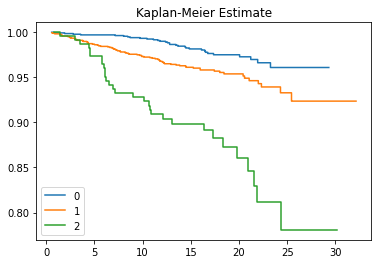

In [36]:
fig, ax = plt.subplots()

for group_name, group_data in breast_data.groupby("pd"):
    time, prob_survival = kaplan_meier_estimator(
        group_data.fate == 1, group_data.follow
    )
    ax.step(time, prob_survival, where="post", label=f"{group_name}")

ax.legend(loc="best")
ax.set_title("Kaplan-Meier Estimate")

The age distribution differs among age groups too, therefore it is unclear whether the difference in survival is truly due to the tumor type (`pd`) or age.

In [37]:
breast_data.groupby("pd")["entage"].mean().to_frame()

,entage
pd,
0,40.208999
1,42.891908
2,45.827586


## Estimator of the survival function of the exponential distribution

### Find optimal lambda estimate 
\begin{equation} \boxed{\hat\lambda=\frac{\sum_{i=1}^{n}{\delta}_{i}}{\sum_{i=1}^{n}y_i}}\end{equation}

Survival function:
\begin{equation}\boxed{ S_{\lambda}(y_i) = exp({-}{\frac{\sum_{i=1}^{n}{\delta}_{i}}{\sum_{i=1}^{n}y_i}} y_i)}\end{equation}

In [38]:
lambda_val = np.zeros(3)

i = 0
for group_name, group_data in breast_data.groupby("pd"):
  lambda_val[i] = np.sum(group_data.fate == 1)/np.sum(group_data.follow)
  i += 1
print(lambda_val)

[0.0013098  0.00262674 0.00785049]


Text(0.5, 0, 'time')

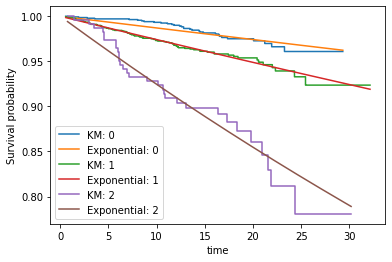

In [39]:
fig, ax = plt.subplots()

i = 0
for group_name, group_data in breast_data.groupby("pd"):
  time, prob_survival = kaplan_meier_estimator(
        group_data.fate == 1, group_data.follow
    )
  ax.step(time, prob_survival, where="post", label=f"KM: {group_name}")
  prob_exp = np.exp(-lambda_val[i]* time)
  ax.plot(time, prob_exp, label=f"Exponential: {group_name}")
  i += 1

ax.legend(loc="best")
ax.set_ylabel("Survival probability")
ax.set_xlabel("time")

#ax.set_title("Exponential Distribution and Kaplan Meier")

Text(0.5, 1.0, 'Exponential Distribution')

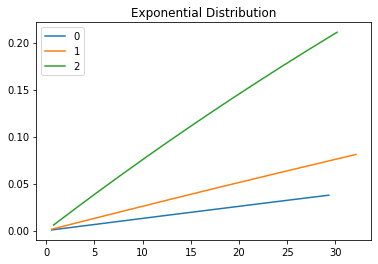

In [29]:
fig, ax = plt.subplots()

i = 0
for group_name, group_data in breast_data.groupby("pd"):
  time  = np.sort(group_data.follow)
  prob = np.exp(-lambda_val[i]* time)
  ax.plot(time, prob, label=f"{group_name}")
  i += 1

ax.legend(loc="best")
ax.set_title("Exponential Distribution")

In [40]:
breast_data.groupby("pd")["entage"].mean().to_frame()

,entage
pd,
0,40.208999
1,42.891908
2,45.827586


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f28604efbd0>,
      dtype=object)

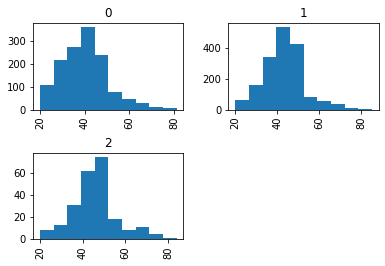

In [42]:
breast_data['entage'].hist(by=breast_data['pd'])
